In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.risk.final_model_loss_train_risk import *
from model.final_model.risk.final_model_risk import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.risk.plot import *



import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [4]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [ ]:
# from torch.utils.data import Subset


# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=False,collate_fn=collate_fn )

# batch = next(iter(train_loader))
# *_, original_indices = batch
# small_ids = original_indices.tolist()

# small_subset = Subset(dataset_train, small_ids)

# small_train_loader = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=True,
#     collate_fn=collate_fn
# )
# small_train_loader_p = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=False,
#     collate_fn=collate_fn
# )

In [5]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            gamma=150, beta=10, kappa=10,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep30: Calculating global target P...


[Joint] Ep40: Calculating global target P...


[Joint] Ep50: Calculating global target P...


[Joint] Early stopping at epoch 51 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


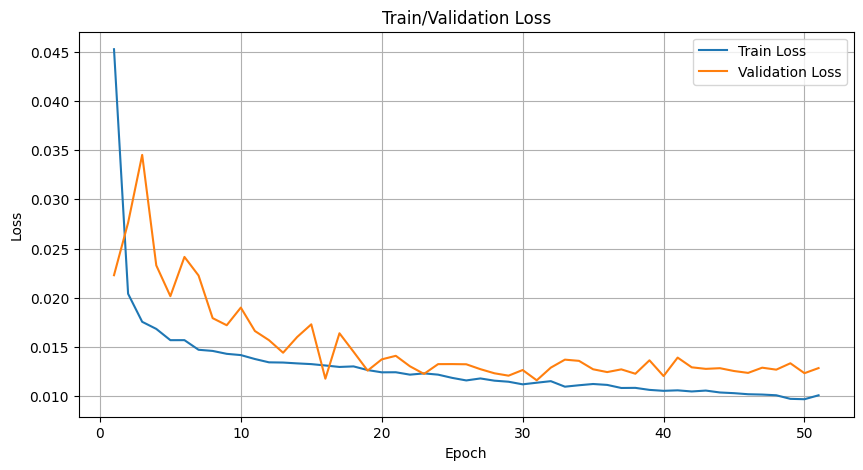

In [5]:
plot_training_history(history)

In [ ]:
# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30/best_joint.pth'
# model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score

def test_patient_outcome_model(model, test_loader, device):
    model.eval()
    all_risk_preds, all_risk_trues = [], []

    # record per‐patient mean predictions and true categories, for κ
    per_patient_mean_risk = []
    per_patient_cats = []

    with torch.no_grad():
        for _, flat_data, ts_data, graph_data, risk, ts_lengths, categories, _, _ in test_loader:
            flat_data, ts_data, ts_lengths = flat_data.to(device), ts_data.to(device), ts_lengths.to(device)
            graph_data = graph_data.to(device)

            # forward
            output = model(flat_data, graph_data, ts_data, ts_lengths)
            mask_seq, _ = model.generate_mask(ts_data.size(1), ts_lengths)
            mask_float = mask_seq.float()  # [B, T]

            # --- collect raw preds and truths for RMSE/R² ---
            risk_pred = output["risk_scores"]        # [B, T]
            risk_true = risk.to(device)             # [B, T]

            # flatten valid entries
            mask_flat = mask_float.view(-1).bool()
            preds_flat = risk_pred.view(-1)[mask_flat].cpu().numpy()
            trues_flat = risk_true.view(-1)[mask_flat].cpu().numpy()

            all_risk_preds.extend(preds_flat)
            all_risk_trues.extend(trues_flat)

            # --- per‐patient mean risk & category for κ ---
            sum_pred = (risk_pred * mask_float).sum(dim=1)          # [B]
            count = mask_float.sum(dim=1).clamp(min=1)              # [B]
            mean_pred = (sum_pred / count).cpu().numpy()           # [B]
            per_patient_mean_risk.extend(mean_pred.tolist())

            per_patient_cats.extend(categories.cpu().tolist())

    # --- regression metrics ---
    mse = mean_squared_error(all_risk_trues, all_risk_preds)
    rmse = mse**0.5
    r2   = r2_score(all_risk_trues, all_risk_preds)

    print(f"Test Risk    → RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # --- Cohen's κ on discrete categories (requires mapping preds → categories) ---
    # Here we assume categories ∈ {0,1,2,3}.  We discretize the mean risk prediction
    # to the nearest integer in [0,3].
    import numpy as np
    true_cats = np.array(per_patient_cats)
    # scale mean_risk from [0,1] to [0,3], then round and clip
    pred_cats = np.clip(np.round(np.array(per_patient_mean_risk) * 3), 0, 3).astype(int)
    kappa     = cohen_kappa_score(true_cats, pred_cats)

    print(f"Test Risk κ→ Cohen's κ: {kappa:.4f}")

    # per‐category loss summary (optional)
    hist_cat = {}
    losses_t = torch.tensor([
        (p - t)**2 for p, t in zip(per_patient_mean_risk, per_patient_mean_risk)  # here just placeholder
    ])  # replace with your per‐patient loss if needed
    cats_t   = torch.tensor(per_patient_cats)
    for i in range(4):
        sel = cats_t == i
        if sel.any():
            group = losses_t[sel]
            hist_cat[i] = (group.mean().item(), int(sel.sum().item()))

    return {
        "rmse": rmse,
        "r2": r2,
        "kappa": kappa,
        "per_patient_cat_loss": hist_cat,
    }


In [69]:
output= test_patient_outcome_model(model, test_loader, device)

Test Risk    → RMSE: 0.1055, R²: -0.0157
Test Risk κ→ Cohen's κ: 0.0478


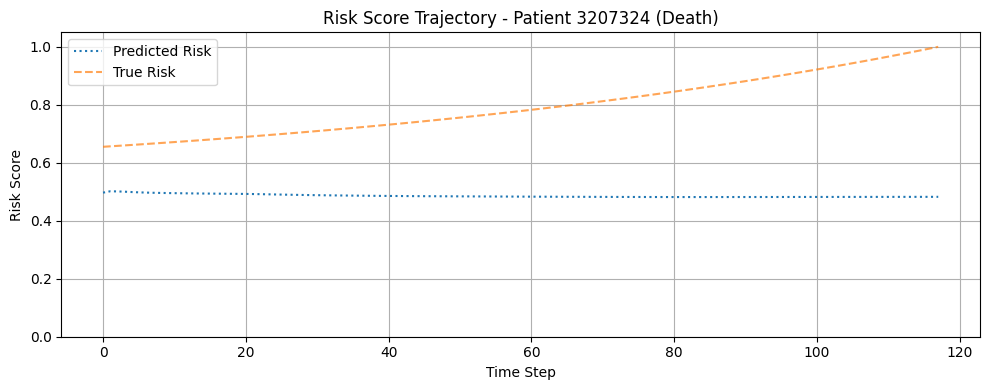

In [11]:
plot_patient_risk_score(model, test_loader, patient_index=400, device=device)

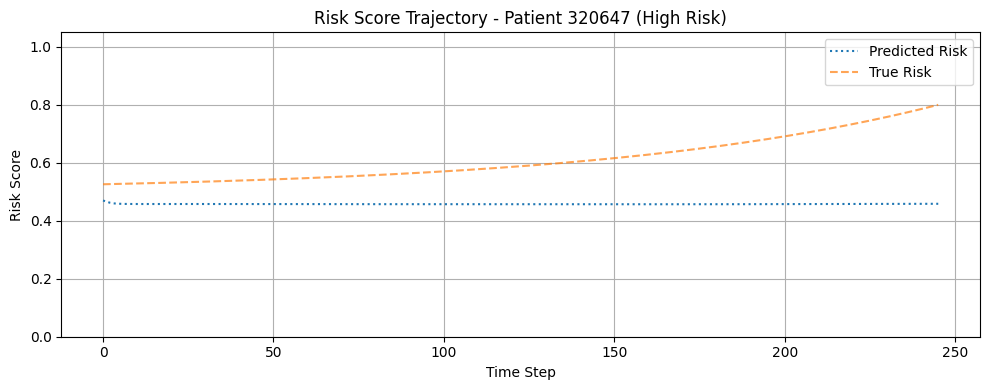

In [10]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

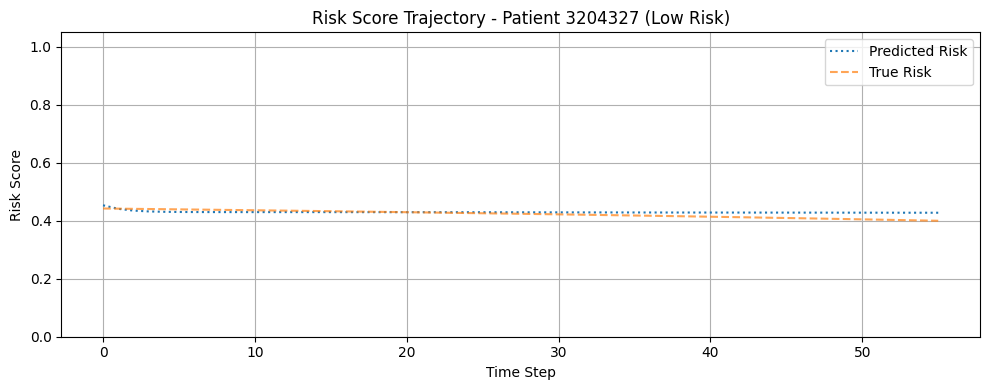

In [31]:
plot_patient_risk_score(model, test_loader, patient_index=397, device=device)

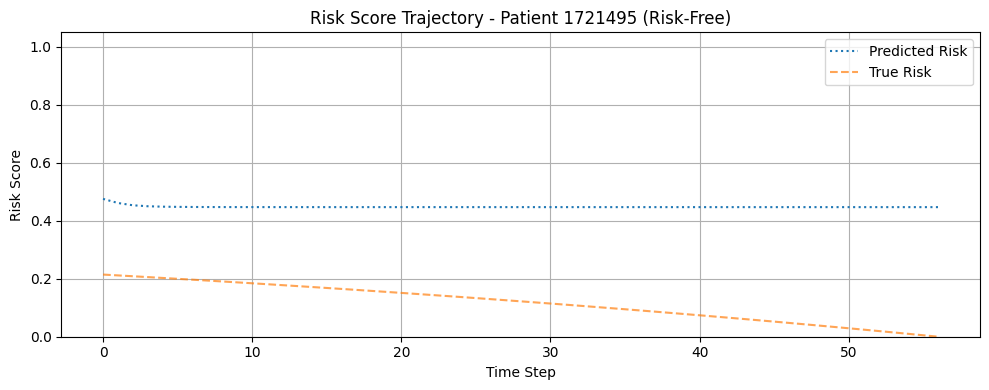

In [60]:
plot_patient_risk_score(model, test_loader, patient_index=51, device=device)

In [ ]:
cat0_indices = []
for batch in test_loader:
    pid, flat, ts, graph, risk, lengths, categories, mort, orig_idx = batch
    mask0 = (categories == 0)
    cat0_indices.extend(orig_idx[mask0].tolist())

print("test_loader 中 cat=0 的样本索引：", cat0_indices)

test_loader 中 cat=0 的样本索引： [18, 51, 48, 61, 53, 46, 43, 77, 75, 88, 71, 122, 123, 127, 117, 109, 114, 131, 161, 194, 241, 279, 303, 302, 327, 330, 418]


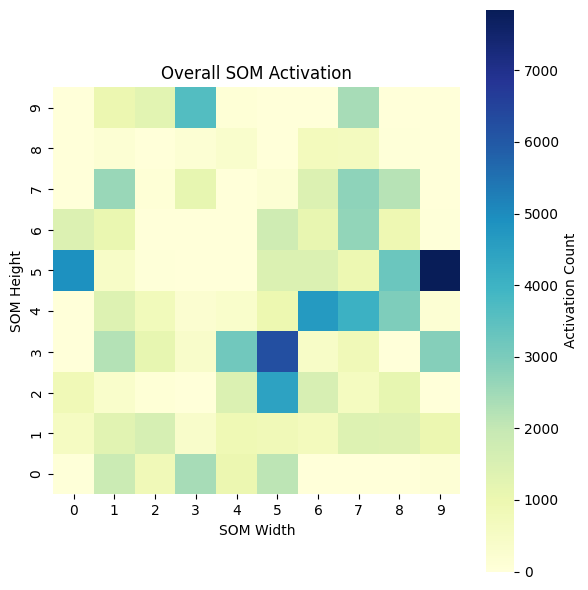

In [61]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


--> Heatmap computation complete.


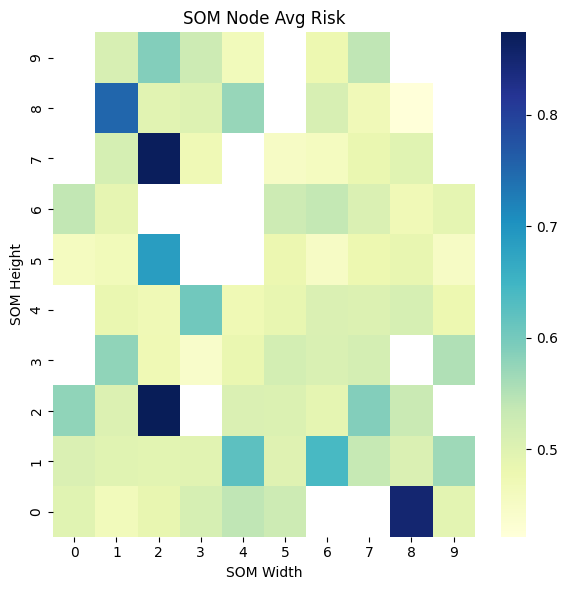

In [63]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


--> Heatmap computation complete.
--- Searching for specified patient IDs: ['320647', '3207324'] ---


Searching for patients:  80%|████████  | 12/15 [00:09<00:02,  1.31it/s]

  -> Found 2 target(s) in current batch. Running forward pass...


Searching for patients:  80%|████████  | 12/15 [00:10<00:02,  1.10it/s]

    -> Computed trajectory for Patient ID: 320647 (Category: 2)
    -> Computed trajectory for Patient ID: 3207324 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [0, 123, 245]



/home/mei/nas/docker/thesis/model_train/model/final_model/risk/plot.py:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


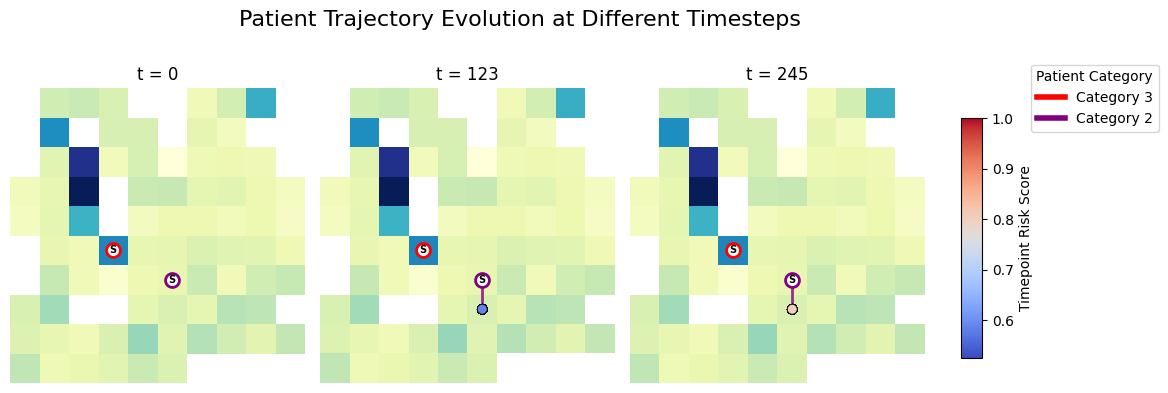

In [67]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

# --- 2. 计算目标病人的轨迹 ---
patient_ids = ['320647', '3207324'] 

targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    0, 
    max_len // 2, 
    max_len - 1 
]
snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

In [66]:
save_path2= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_smooth"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model2, history2 = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path2, 
            gamma=200, beta=200, kappa=150,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 26 due to no improvement for 20 epochs.
[Joint] Loading best model weights.
